❌ File not found for HCHO_TROP


/var/folders/91/tmzh46hs1_vghy7y94yp_4_w0000gn/T/ipykernel_85271/2637647603.py:52: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[0] = pd.to_datetime(df[0], errors='coerce')


HCHO_TOTAL: ✅ 69147 valid rows | Flags: [12.0, 11.0, 10.0]
❌ File not found for NO2_TROP


/var/folders/91/tmzh46hs1_vghy7y94yp_4_w0000gn/T/ipykernel_85271/2637647603.py:52: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[0] = pd.to_datetime(df[0], errors='coerce')


NO2_TOTAL: ✅ 529607 valid rows | Flags: [12.0, 11.0, 10.0]
❌ File not found for O3
❌ File not found for SO2
❌ File not found for H2O


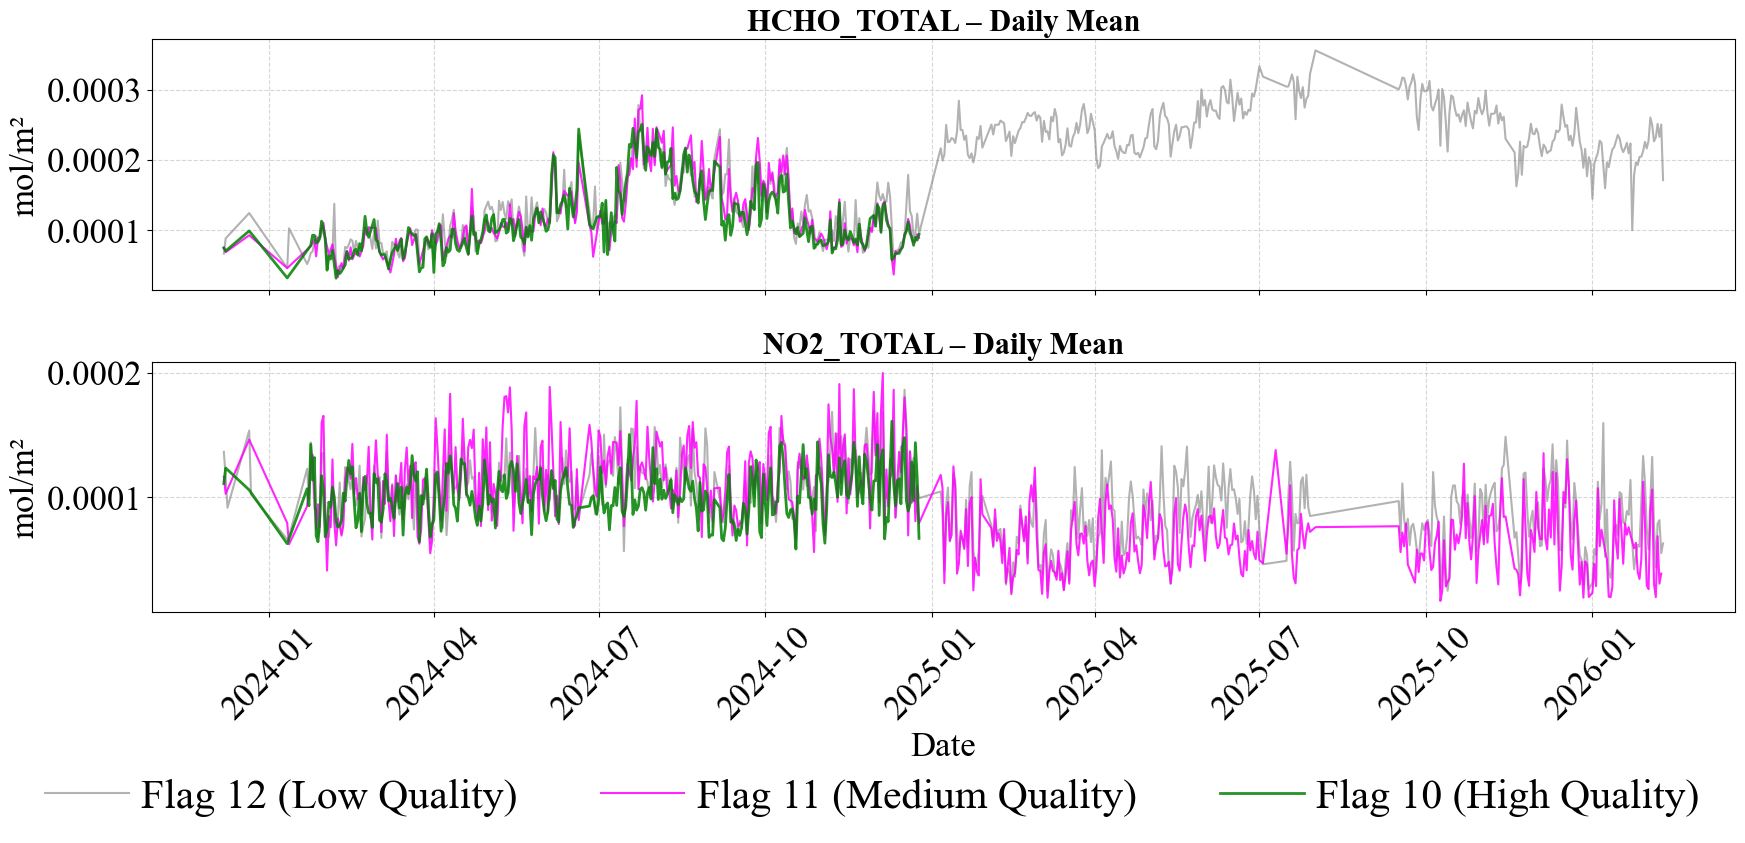

✅ Saved daily mean plot: Data/TimeSeries_Plots/All_Gases_DailyMean_TimeSeries_SingleLegend.png


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Setup paths ---
data_dir = r'Data'
output_dir = os.path.join(data_dir, 'TimeSeries_Plots')
os.makedirs(output_dir, exist_ok=True)

# --- Gas-specific column indices ---
gas_configs = {
    'HCHO_TROP':  {'file_tag': 'rfuh', 'flag_col': 41, 'value_col': 48},
    'HCHO_TOTAL': {'file_tag': 'rfus', 'flag_col': 35, 'value_col': 38},
    'NO2_TROP':   {'file_tag': 'rnvh', 'flag_col': 52, 'value_col': 61},
    'NO2_TOTAL':  {'file_tag': 'rnvs', 'flag_col': 32, 'value_col': 38},
    'O3':         {'file_tag': 'rout', 'flag_col': 35, 'value_col': 38},
    'SO2':        {'file_tag': 'rsus', 'flag_col': 32, 'value_col': 39},
    'H2O':        {'file_tag': 'rwvt', 'flag_col': 32, 'value_col': 39},
}

flag_colors = {
    10.0: 'green',
    11.0: 'magenta',
    12.0: 'gray'
}

flag_labels = {
    10.0: 'Flag 10 (High Quality)',
    11.0: 'Flag 11 (Medium Quality)',
    12.0: 'Flag 12 (Low Quality)'
}

def read_file(file_path, flag_col, value_col):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
    except:
        with open(file_path, 'r', encoding='ISO-8859-1') as f:
            lines = f.readlines()

    data_start = next(i for i, line in enumerate(lines) if line.startswith('---')) + 1
    data_lines = [
        line.strip().split() for line in lines[data_start:]
        if line.strip() and len(line.split()) > max(flag_col, value_col)
    ]

    df = pd.DataFrame(data_lines)
    if df.empty:
        return pd.DataFrame()

    df[0] = pd.to_datetime(df[0], errors='coerce')
    df[flag_col] = pd.to_numeric(df[flag_col], errors='coerce')
    df[value_col] = pd.to_numeric(df[value_col], errors='coerce')

    df = df.rename(columns={0: 'time', flag_col: 'Flag', value_col: 'Value'})
    df = df[df['Flag'].isin([10.0, 11.0, 12.0])]
    df = df[['time', 'Flag', 'Value']].dropna()

    lower = df['Value'].quantile(0.01)
    upper = df['Value'].quantile(0.99)
    df = df[(df['Value'] >= lower) & (df['Value'] <= upper)]

    return df

all_data = {}
for gas_name, config in gas_configs.items():
    tag = config['file_tag']
    files = [f for f in os.listdir(data_dir) if tag in f and f.endswith('.txt')]
    if not files:
        print(f"❌ File not found for {gas_name}")
        continue

    file_path = os.path.join(data_dir, files[0])
    df = read_file(file_path, config['flag_col'], config['value_col'])
    if not df.empty:
        print(f"{gas_name}: ✅ {len(df)} valid rows | Flags: {df['Flag'].unique().tolist()}")
        all_data[gas_name] = df
    else:
        print(f"⚠️ No valid data for {gas_name}")

# --- Plotting ---
if not all_data:
    print("🚫 No valid data found for any gas.")
else:
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': 'Times New Roman',
        'font.size': 25,
        'axes.titlesize': 25,
        'axes.labelsize': 25,
        'xtick.labelsize': 25,
        'ytick.labelsize': 25,
        'legend.fontsize': 30
    })

    n = len(all_data)
    fig, axes = plt.subplots(nrows=n, figsize=(18, 4.5 * n), sharex=True)
    if n == 1:
        axes = [axes]

    flag_priority = [12.0, 11.0, 10.0]
    added_flags = set()
    handles = []
    labels = []

    for ax, (gas_name, df) in zip(axes, all_data.items()):
        df['Date'] = df['time'].dt.date
        for flag in flag_priority:
            group = df[df['Flag'] == flag]
            if group.empty:
                continue
            daily_mean = group.groupby('Date')['Value'].mean()
            line, = ax.plot(daily_mean.index, daily_mean.values,
                            color=flag_colors.get(flag, 'black'),
                            linewidth=2 if flag == 10.0 else 1.5,
                            alpha=0.6 if flag == 12.0 else 0.85)
            if flag not in added_flags:
                handles.append(line)
                labels.append(flag_labels[flag])
                added_flags.add(flag)

        ax.set_title(f"{gas_name} – Daily Mean", fontsize=22, weight='bold')
        ax.set_ylabel("mol/m²")
        ax.grid(True, linestyle='--', alpha=0.5)

    axes[-1].set_xlabel("Date")
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0.08, 1, 1])

    # --- Legend just below subplots ---
    fig.legend(handles, labels,
               loc='lower center',
               bbox_to_anchor=(0.5, 0.02),
               ncol=3,
               frameon=False,
               labelspacing=0.1,
               handletextpad=0.3)

    save_path = os.path.join(output_dir, "All_Gases_DailyMean_TimeSeries_SingleLegend.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved daily mean plot: {save_path}")


/var/folders/91/tmzh46hs1_vghy7y94yp_4_w0000gn/T/ipykernel_85271/2843470310.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[0] = pd.to_datetime(df[0], errors='coerce') # UTC Time


✅ Loaded NO2_TOTAL: 529607 rows.


/var/folders/91/tmzh46hs1_vghy7y94yp_4_w0000gn/T/ipykernel_85271/2843470310.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[0] = pd.to_datetime(df[0], errors='coerce') # UTC Time


✅ Loaded HCHO_TOTAL: 69147 rows.
❌ File not found for O3 (Looking for tag: rout)


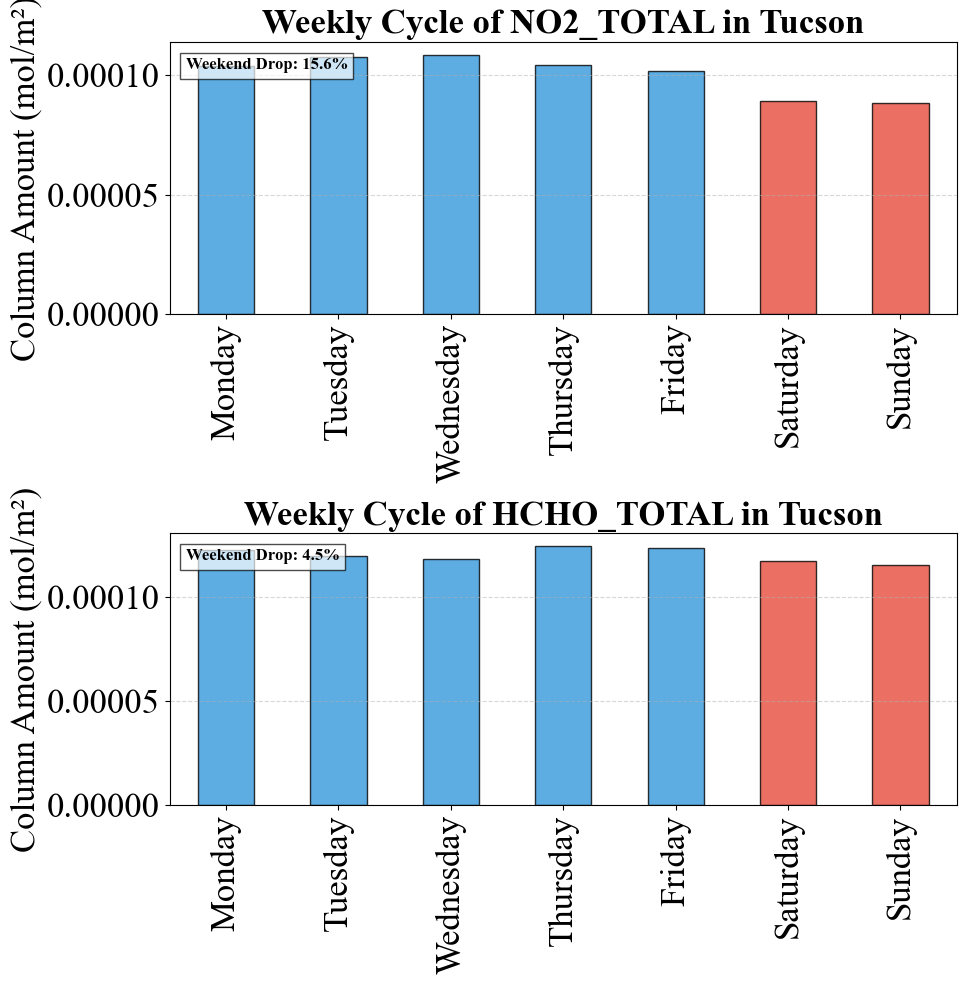

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- 1. Setup paths ---
# Update this to where your Pandora files are stored
data_dir = r'Data'
output_dir = os.path.join(data_dir, 'EXCITE_Analysis')
os.makedirs(output_dir, exist_ok=True)

# --- 2. Gas-specific column indices (Verified for L2 p1-8 files) ---
# Note: flag_col/value_col use 0-based indexing (Col 36 in file = 35 in code)
gas_configs = {
    'NO2_TOTAL':  {'file_tag': 'rnvs3p1-8', 'flag_col': 35, 'value_col': 38},
    'HCHO_TOTAL': {'file_tag': 'rfus5p1-8', 'flag_col': 35, 'value_col': 38},
    'O3':         {'file_tag': 'rout', 'flag_col': 35, 'value_col': 38},
}

# --- 3. Robust Read Function ---
def read_file(file_path, flag_col, value_col):
    # Using latin1 to bypass the degree symbol (°) encoding error
    try:
        with open(file_path, 'r', encoding='latin1') as f:
            lines = f.readlines()
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return pd.DataFrame()

    # Find where header ends
    try:
        data_start = next(i for i, line in enumerate(lines) if line.startswith('---')) + 1
    except StopIteration:
        print(f"Could not find data start '---' in {file_path}")
        return pd.DataFrame()

    data_lines = [
        line.strip().split() for line in lines[data_start:]
        if line.strip() and len(line.split()) > max(flag_col, value_col)
    ]

    df = pd.DataFrame(data_lines)
    if df.empty:
        return pd.DataFrame()

    # Convert types
    df[0] = pd.to_datetime(df[0], errors='coerce') # UTC Time
    df[flag_col] = pd.to_numeric(df[flag_col], errors='coerce')
    df[value_col] = pd.to_numeric(df[value_col], errors='coerce')

    df = df.rename(columns={0: 'time', flag_col: 'Flag', value_col: 'Value'})
    
    # Filter for standard quality flags 10, 11, 12
    df = df[df['Flag'].isin([10.0, 11.0, 12.0])]
    df = df[['time', 'Flag', 'Value']].dropna()

    # Outlier removal (1st and 99th percentile)
    if not df.empty:
        lower = df['Value'].quantile(0.01)
        upper = df['Value'].quantile(0.99)
        df = df[(df['Value'] >= lower) & (df['Value'] <= upper)]

    return df

# --- 4. Load Data ---
all_data = {}
for gas_name, config in gas_configs.items():
    tag = config['file_tag']
    # Scan directory for the right file tag
    files = [f for f in os.listdir(data_dir) if tag in f and f.endswith('.txt')]
    if not files:
        print(f"❌ File not found for {gas_name} (Looking for tag: {tag})")
        continue

    file_path = os.path.join(data_dir, files[0])
    df_gas = read_file(file_path, config['flag_col'], config['value_col'])
    
    if not df_gas.empty:
        print(f"✅ Loaded {gas_name}: {len(df_gas)} rows.")
        all_data[gas_name] = df_gas

# --- 5. Generate Day-of-Week Plot ---
if not all_data:
    print("🚫 No data found. Check your file paths and column indices.")
else:
    plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
    n = len(all_data)
    fig, axes = plt.subplots(nrows=n, figsize=(10, 5 * n))
    if n == 1: axes = [axes]

    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    for i, (gas_name, df) in enumerate(all_data.items()):
        ax = axes[i]
        
        # Shift to Tucson Local Time (MST = UTC-7)
        df['time_local'] = df['time'] - pd.Timedelta(hours=7)
        df['weekday'] = df['time_local'].dt.day_name()
        
        # Group by weekday and get mean
        # Using Flag 10 (High Quality) for the final average
        best_data = df[df['Flag'] == 10.0]
        if best_data.empty: best_data = df # Use all flags if 10 is missing
        
        weekly_avg = best_data.groupby('weekday')['Value'].mean().reindex(weekday_order)
        
        # Color weekends (Sat/Sun) differently
        colors = ['#3498db' if d not in ['Saturday', 'Sunday'] else '#e74c3c' for d in weekday_order]
        weekly_avg.plot(kind='bar', ax=ax, color=colors, edgecolor='black', alpha=0.8)
        
        ax.set_title(f"Weekly Cycle of {gas_name} in Tucson", fontweight='bold')
        ax.set_ylabel("Column Amount (mol/m²)")
        ax.set_xlabel("")
        ax.grid(axis='y', linestyle='--', alpha=0.5)

        # Calculate and display the weekend drop
        workday_mean = weekly_avg['Monday':'Friday'].mean()
        weekend_mean = weekly_avg['Saturday':'Sunday'].mean()
        drop = ((workday_mean - weekend_mean) / workday_mean) * 100
        ax.text(0.02, 0.9, f"Weekend Drop: {drop:.1f}%", transform=ax.transAxes, 
                weight='bold', bbox=dict(facecolor='white', alpha=0.7))

    plt.tight_layout()
    plt.show()